In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

import nbi

In [2]:
print(nbi.__version__)

0.3.1


here we consider a very simple sine wave model, where t is time, f is frequency, A is amplitude, and $\phi_0$ is initial phase:

$f(t) = A\cdot\sin(f\cdot t+\phi_0$)

In [3]:
t = np.linspace(0,1,50)
def sine(param):
    phi0, A, freq = param
    return np.sin(t * freq + phi0) * A

In [4]:
# define prior space of interest

from scipy.stats import uniform, truncnorm
prior = {
    'phi0': uniform(loc=0, scale=np.pi*2),
    'A': uniform(loc=1, scale=4),
    'freq': uniform(loc=2*np.pi, scale=10*np.pi)
}
labels = list(prior.keys())
priors = [prior[k] for k in labels]

# single inference (sequential training)

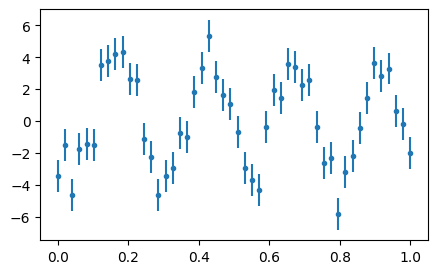

In [5]:
plt.figure(figsize=(5,3))

np.random.seed(0)

# draw random parameter from prior
y_true = [var.rvs(1)[0] for var in priors]

# add fixed gaussian noise of 0.5
x_err = 1
x_obs = sine(y_true) + np.random.normal(size=50) * x_err
plt.errorbar(t, x_obs, yerr=x_err, fmt='.')

plt.show()

In [8]:
# hyperparameters for the normalizing flow
flow_config = {
    'n_dims': 3,
    'flow_hidden': 32,
    'num_cond_inputs': 32,
    'num_blocks': 4
}

# the NBI package provides predefined featurizer NNs for certain types of data
# including 1D sequences
featurizer_config = {
    'type': 'sequence',
    'dim_in': 1,
    'dim_conv_max': 256,
    'depth': 3
}

# initialize NBI engine
engine = nbi.NBI(
    flow=flow_config,
    featurizer=featurizer_config,
    simulator=sine,
    priors=priors,
    labels=labels,
    n_jobs=10
)

Generating simulations


512it [00:00, 975.50it/s] 
/Users/Keming/anaconda3/envs/nbi-py38/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/nbi-py38/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/nbi-py38/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/nbi-py38/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('res

Effective sample size for current/all rounds 3.1/3.1

---------------------- Round: 0 ----------------------


- Val, Loglike in nats: -0.101761: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 1605.91it/s]


Samples outside prior N = 1306
Generating simulations


382it [00:00, 998.62it/s]


Effective sample size for current/all rounds 17.6/20.7


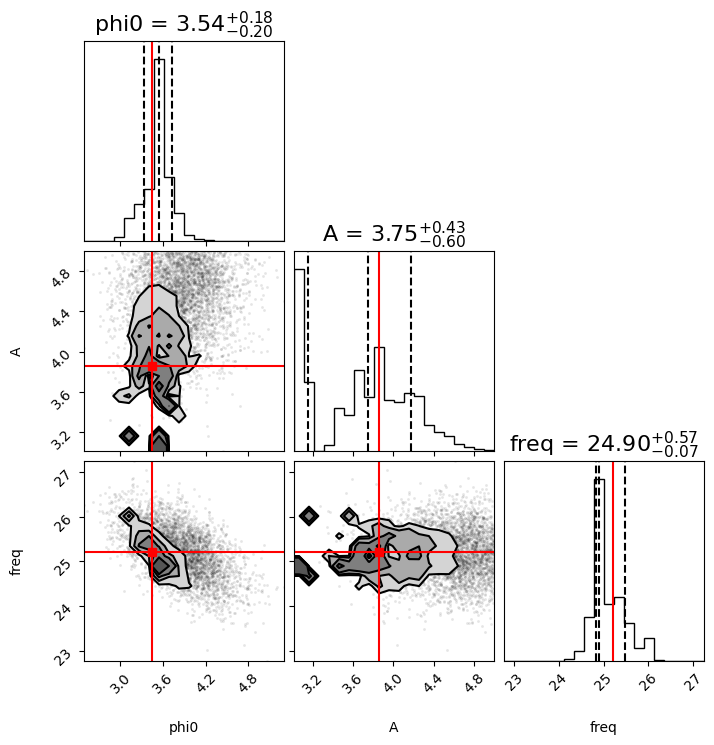

reweighted posterior from all rounds


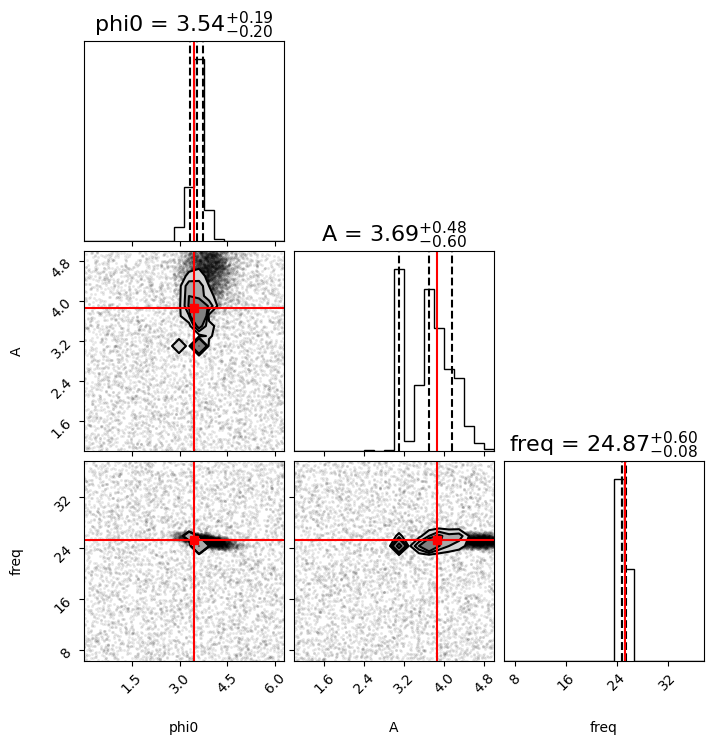

In [9]:
engine.fit(
    x_obs=x_obs,
    y_true=y_true,
    n_sims=5120,
    n_rounds=1,
    n_epochs=10,
    noise=np.array([2]*50)
)

Samples outside prior N = 526
surrogate posterior


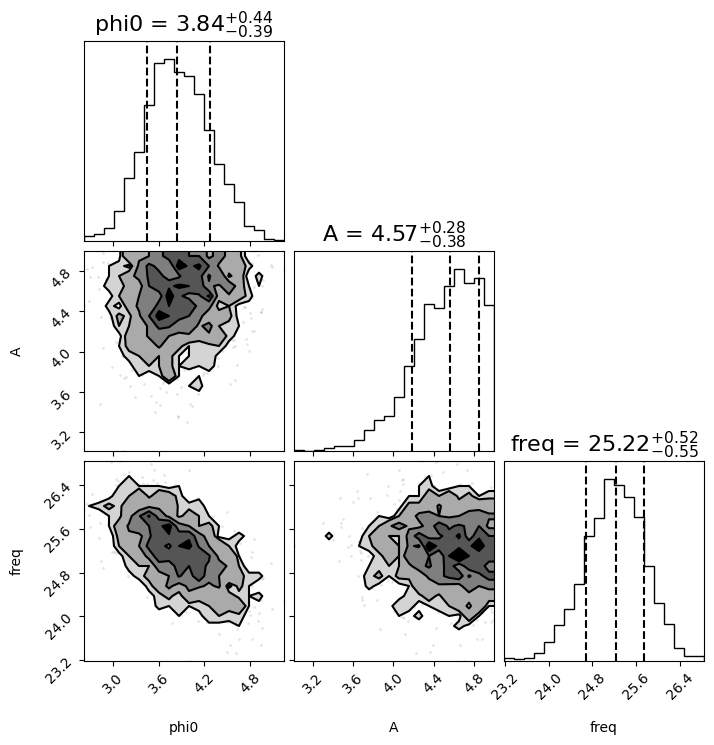

Generating simulations


148it [00:00, 1413.06it/s]


Effective Sample Size = 43.4
Sampling efficiency = 2.2%


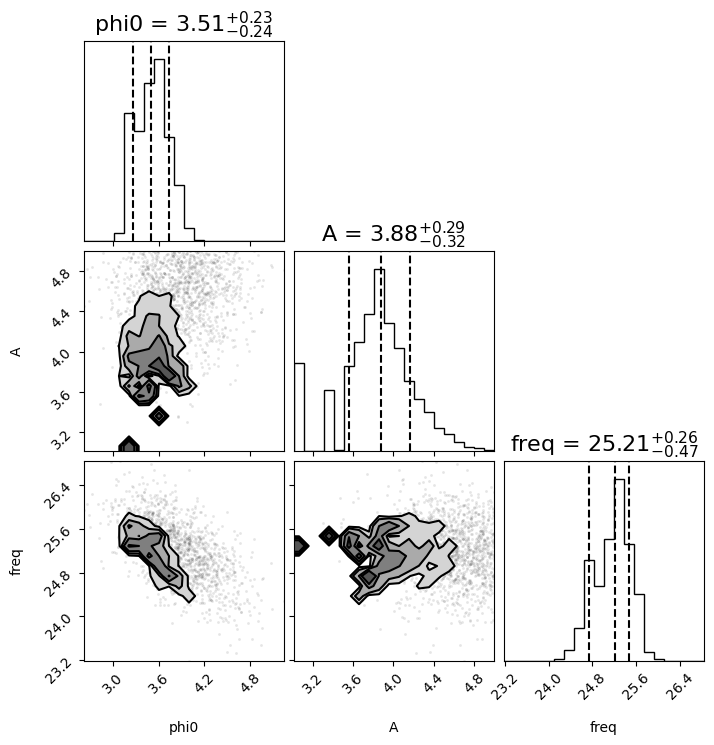

In [10]:
y_pred, weights = engine.predict(x_obs, x_err=np.array([2]*50), n_samples=2000, corner=True, corner_reweight=True)

Loaded state from round  1
Samples outside prior N = 4
Generating simulations



0it [00:00, ?it/s]
121it [00:00, 1203.80it/s]
244it [00:00, 1217.60it/s]
366it [00:00, 720.31it/s] 
455it [00:00, 761.62it/s]
564it [00:00, 728.37it/s]
687it [00:00, 856.63it/s]
1000it [00:01, 993.20it/s][A


Sampling efficiency = 22.1%
Requires N = 35296 more simulations
Samples outside prior N = 7
Generating simulations



0it [00:00, ?it/s]
150it [00:00, 1498.19it/s]
300it [00:00, 1163.57it/s]
421it [00:00, 949.69it/s] 
524it [00:00, 770.17it/s]
607it [00:00, 767.62it/s]
753it [00:00, 950.22it/s]
856it [00:01, 583.24it/s]
961it [00:01, 672.27it/s]
1079it [00:01, 780.32it/s]
1176it [00:01, 584.94it/s]
1254it [00:01, 507.00it/s]
1335it [00:01, 561.83it/s]
1479it [00:02, 717.90it/s]
1610it [00:02, 848.73it/s]
1735it [00:02, 945.18it/s]
1843it [00:02, 923.20it/s]
2009it [00:02, 1111.69it/s]
2228it [00:02, 1398.33it/s]
2378it [00:02, 1096.09it/s]
2505it [00:02, 984.72it/s] 
2617it [00:03, 966.76it/s]
2723it [00:03, 980.45it/s]
2828it [00:03, 869.88it/s]
2921it [00:03, 597.03it/s]
2996it [00:03, 541.14it/s]
3061it [00:04, 475.28it/s]
3194it [00:04, 632.48it/s]
3279it [00:04, 677.34it/s]
3384it [00:04, 762.14it/s]
3529it [00:04, 793.82it/s]


Total effective sample size N = 11400.5


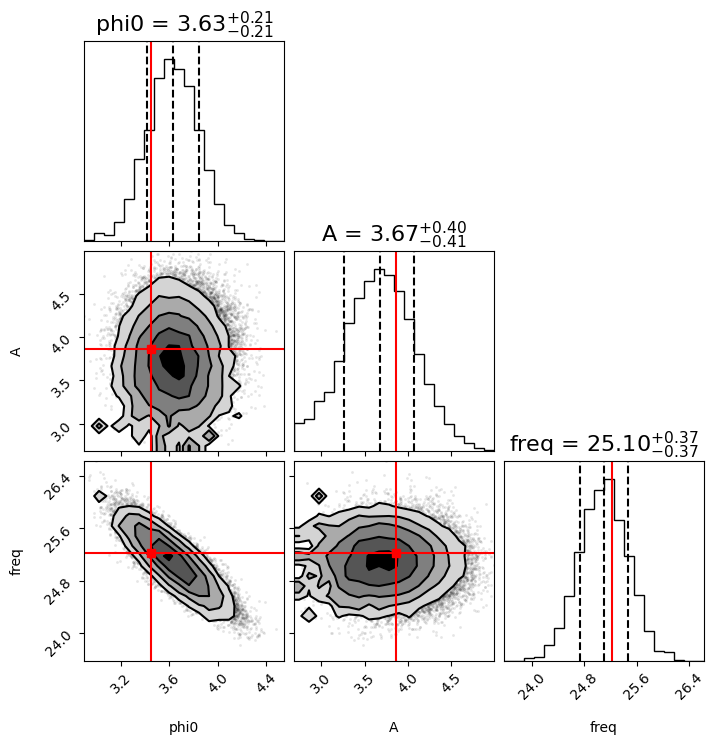

In [15]:
# we terminated training after round 1 is
# has sampling efficiency 1100/5120 ~ 20%
# now we want to generate posterior sample of effective size 10000
engine.load_prev_state(1)
ys, weights = engine.predict(neff_target=10000, corner_after=True)

<ErrorbarContainer object of 3 artists>

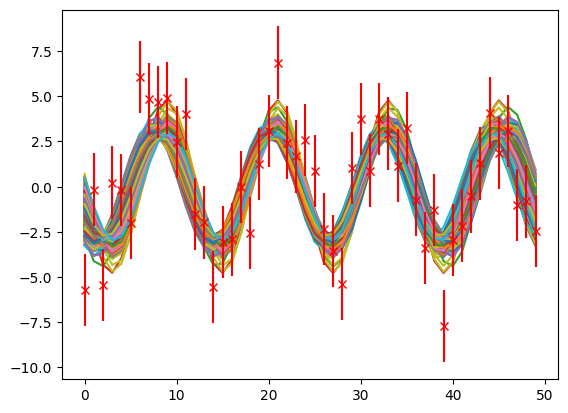

In [27]:
# posterior predictive checks
# select top 1000 best fitting parameters
ind = np.argsort(weights)
xs = np.array([sine(ys[i]) for i in ind[-1000:]])
plt.plot(xs.T)
plt.errorbar(range(50), x_obs, yerr=2, fmt='rx')

# Multiple inference (amortized training)
if we care about a large number of different x_obs, then train nbi for only 1 round on more samples generated from the prior space of interest

In [5]:
# let's say we have a large set of observed sine curves with different noise levels
# instead of initializing the NBI engine with fixed noise, we have provide it with a
# noise function that takes in noise free "x" and returns a noisified x

def noise(x, y):
    rand = np.random.normal(0, 1, size=x.shape[0])
    
    # let's say x_err is drawn from [0.5, 2.5]
    x_err = np.random.uniform() * 2 + 0.5
    x_noise = x + rand * x_err
    return x_noise, y

In [6]:
# hyperparameters for the normalizing flow
flow_config = {
    'flow_hidden': 32,
    'num_cond_inputs': 32,
    'num_blocks': 4
}

# the NBI package provides predefined featurizer NNs for certain types of data
# including 1D sequences
featurizer_config = {
    'type': 'sequence',
    'dim_in': 1,
    'dim_conv_max': 256,
    'depth': 3
}


# initialize NBI engine
engine = nbi.NBI(
    featurizer_config,
    flow_config=flow_config,
    simulator=sine,
    noise=noise,
    prior=prior,
    labels=labels,
    n_jobs=10,
    X=X,                      # To use saved training set: X = np.load('test/0_x.npy')
    Y=Y,                      # To use saved training set: Y = np.load('test/0_y.npy')
)

engine.fit(
    n_rounds=1,
    n_per_round=5120*2,
    n_epochs=10
)

Generating simulations


1024it [00:00, 1436.08it/s]
/Users/Keming/anaconda3/envs/nbi-py38/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/nbi-py38/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/nbi-py38/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/nbi-py38/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('re


---------------------- Round: 0 ----------------------


Epoch 0: Train, Loglike in nats: -2.622880: 100%|█| 9216/9216 [00:14<00:00, 630.
- Val, Loglike in nats: -2.401485: 100%|██| 1024/1024 [00:00<00:00, 1584.25it/s]
Epoch 1: Train, Loglike in nats: -1.534493: 100%|█| 9216/9216 [00:13<00:00, 693.
- Val, Loglike in nats: -0.981693: 100%|██| 1024/1024 [00:00<00:00, 1642.49it/s]
Epoch 2: Train, Loglike in nats: -0.448537: 100%|█| 9216/9216 [00:13<00:00, 689.
- Val, Loglike in nats: -0.020248: 100%|██| 1024/1024 [00:00<00:00, 1585.64it/s]
Epoch 3: Train, Loglike in nats: 0.198608: 100%|█| 9216/9216 [00:13<00:00, 695.6
- Val, Loglike in nats: 0.345228: 100%|███| 1024/1024 [00:00<00:00, 1607.67it/s]
Epoch 4: Train, Loglike in nats: 0.502538: 100%|█| 9216/9216 [00:13<00:00, 694.9
- Val, Loglike in nats: 0.803542: 100%|███| 1024/1024 [00:00<00:00, 1648.89it/s]
Epoch 5: Train, Loglike in nats: 0.833091: 100%|█| 9216/9216 [00:12<00:00, 714.9
- Val, Loglike in nats: 1.042423: 100%|███| 1024/1024 [00:00<00:00, 1655.32it/s]
Epoch 6: Train, Loglike in n

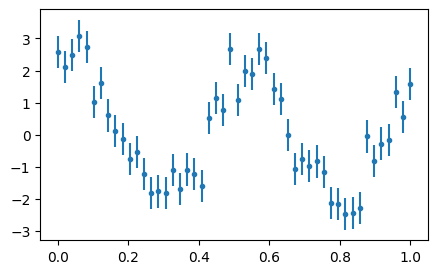

In [7]:
# to do inference with the trained engine, input x_obs and desired effective sample size of the posterior sample

x_err = 0.5
np.random.seed(0)

y_true = [1, 2, 4*np.pi]
x_obs = sine(y_true) + np.random.normal(size=50) * x_err

plt.figure(figsize=(5,3))
plt.errorbar(t, x_obs, yerr=x_err, fmt='.')
plt.show()

Samples outside prior N = 2
surrogate posterior


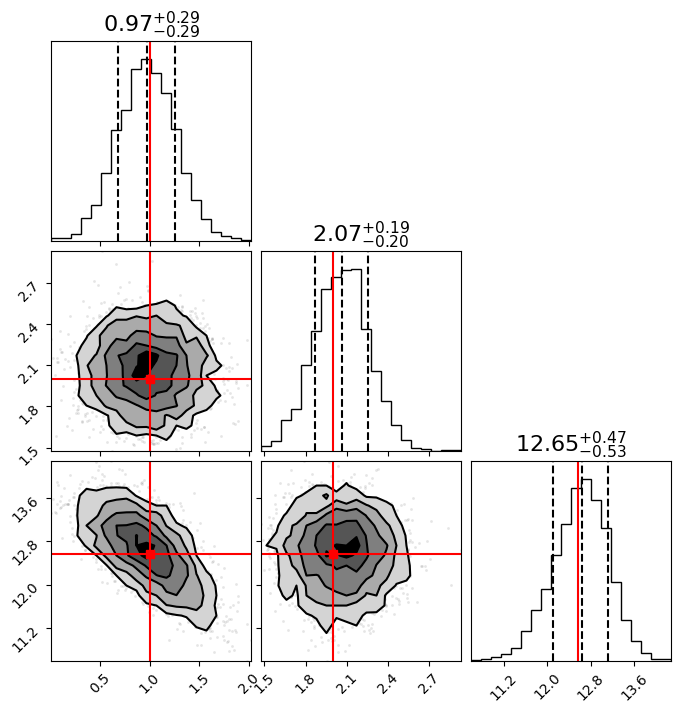

Generating simulations


500it [00:00, 1399.51it/s]


Initial n_eff = 378.9%
Sampling efficiency = 7.6%
Requires N = 60972 more simulations
Samples outside prior N = 25
Generating simulations


6095it [00:06, 880.15it/s] 


Total effective sample size N = 5239.9


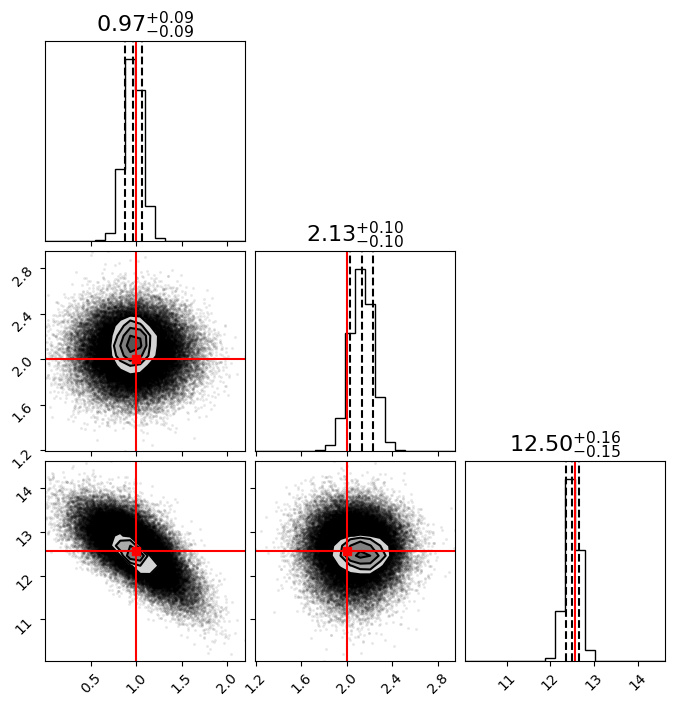

In [29]:
# the first corner plot is the nbi surrogate posterior
# the second corner plot is the importance reweighted posterior
ys, weights = engine.predict(x_obs, x_err=np.array([0.5]), neff_target=5000, y_true=y_true, corner_after=True, corner_before=True)

<ErrorbarContainer object of 3 artists>

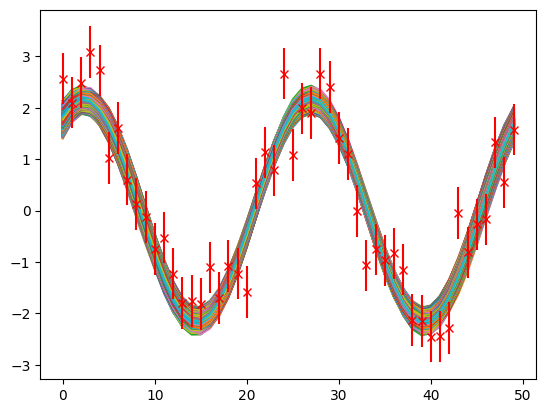

In [31]:
# posterior predictive checks
# select top 1000 best fitting parameters
ind = np.argsort(weights)
xs = np.array([sine(ys[i]) for i in ind[-1000:]])
plt.plot(xs.T)
plt.errorbar(range(50), x_obs, yerr=0.5, fmt='rx')